In [1]:
from __future__ import print_function
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
 
from model import PMF
from evaluations import RMSE

In [2]:
# --------------------------------------------- HYPERPARAMETERS ----------------------------------------------------
# Input batch size for training
batch_size = 64
# Number of maximum epoches to train
epoches = 100
# Enables CUDA training
use_cuda = False
# Generate random seed
seed = 1
# Weight decay
weight_decay = 0.1
# Size of embedding features
embedding_feature_size = 100
# Training ratio
ratio = 0.8
# Learning rate
lr = 0.0001
# Momentum value
momentum = 0.9

In [3]:
# Load datasets
user = pickle.load(open('dataset/user_id_to_num.pkl', 'rb'))
print("Loaded user")
rest = pickle.load(open('dataset/rest_id_to_num.pkl', 'rb'))
print("Loaded rest")
data = np.load('dataset/data.npy')
print("Loaded data")

Loaded user
Loaded rest
Loaded data


In [4]:
NUM_USERS = len(user)
NUM_ITEMS = len(rest)

print(NUM_USERS, NUM_ITEMS)

1245 40829


In [5]:
# Shuffle data
np.random.shuffle(data)
 
# Split data
train_data = data[:int(ratio*data.shape[0])]
vali_data = data[int(ratio*data.shape[0]):int((ratio+(1-ratio)/2)*data.shape[0])]
test_data = data[int((ratio+(1-ratio)/2)*data.shape[0]):]

In [6]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda and use_cuda else "cpu")

In [7]:
torch.manual_seed(seed=seed)
if cuda:
    torch.cuda.empty_cache()
    torch.cuda.manual_seed(seed=seed)

In [8]:
kwargs = {'num_workers':2, 'pin_memory':True} if cuda else {}

In [9]:
class YelpDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        pass
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.data[[idx], :]
            
        return sample[:, [0, 1, 2]].squeeze()

In [10]:
train_dataset = YelpDataset(train_data)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [11]:
valid_dataset = YelpDataset(vali_data)
vald_data_loader = DataLoader(valid_dataset, batch_size=len(vali_data), shuffle=False, **kwargs)
valid_data = next(iter(vald_data_loader))

In [12]:
test_dataset = YelpDataset(test_data)
test_data_loader = DataLoader(test_dataset, batch_size=len(vali_data), shuffle=False, **kwargs)
test_data = next(iter(test_data_loader))

In [13]:
# Initialize model
model = PMF(n_users=NUM_USERS, n_items=NUM_ITEMS, n_factors=embedding_feature_size, no_cuda=use_cuda)
 
# Move model to CUDA if CUDA selected
if cuda:
    model.cuda()
    print("Model moved to CUDA")
 
# Set loss function
loss_function = nn.MSELoss(reduction='sum')
 
# Set optimizer (uncomment Adam for adam)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)

In [14]:
print(f"total batches {len(train_data_loader)}")

total batches 1311


In [15]:
def train(epoch, train_data_loader):
    # Initialize
    model.train()
    epoch_loss = 0.0
    optimizer.zero_grad()
 
    # Go through batches
    for batch_idx, ele in enumerate(train_data_loader):
        # Zero optimizer gradient
        optimizer.zero_grad()
 
        # Extract user_id_nums: row, item_id_nums: col, ratings: val
        row = ele[:, 0]
        col = ele[:, 1]
        val = ele[:, 2]
 
        # Set to variables
        row = Variable(row.long())
        if isinstance(col, list):
            col = tuple(Variable(c.long()) for c in col)
        else:
            col = Variable(col.long())
        val = Variable(val.float())
 
        # Move data to CUDA
        if cuda:
            row = row.cuda()
            col = col.cuda()
            val = val.cuda()
 
        # Train
        preds = model.forward(row, col)
        loss = loss_function(preds, val)
        loss.backward()
        optimizer.step()
 
        # Update epoch loss
        epoch_loss += loss.item()
        
        print(f"Epoch {epoch}, batch_idx {batch_idx}, epoch_loss {loss.item()}", end='\r')
 
    epoch_loss /= len(train_data_loader.dataset)
    return epoch_loss


In [16]:
print('------------------------------------------- Training Model------------------------------------------------')
train_loss_list = []
last_vali_rmse = None
train_rmse_list = []
vali_rmse_list = []
print('parameters are: train ratio:{:f},batch_size:{:d}, epoches:{:d}, weight_decay:{:f}'.format(ratio, batch_size, epoches, weight_decay))
print(model)
 
# Go through epochs
for epoch in range(1, epoches+1):
 
    # Train epoch
    train_epoch_loss = train(epoch, train_data_loader)
 
    # Get epoch loss
    train_loss_list.append(train_epoch_loss)
 
    # Move validation data to CUDA
    if cuda:
        vali_row = Variable(valid_data[:, 0]).long().cuda()
        vali_col = Variable(valid_data[:, 1]).long().cuda()
    else:
        vali_row = Variable(valid_data[:, 0]).long()
        vali_col = Variable(valid_data[:, 1]).long()
 
    # Get validation predictions
    vali_preds = model.predict(vali_row, vali_col)
 
    # Calculate train rmse loss
    train_rmse = np.sqrt(train_epoch_loss)
 
    # Calculate validation rmse loss
    if cuda:
        vali_rmse = RMSE(vali_preds.cpu().data.numpy(), valid_data[:, 2].cpu().data.numpy())
    else:
        vali_rmse = RMSE(vali_preds.data.numpy(), valid_data[:, 2].data.numpy())
 
    # Add losses to rmse loss lists
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)
 
    print('Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}'. \
              format(epoch, train_rmse, vali_rmse))
 
    # Early stop condition
    if last_vali_rmse and last_vali_rmse < vali_rmse:
        break
    else:
        last_vali_rmse = vali_rmse
 

------------------------------------------- Training Model------------------------------------------------
parameters are: train ratio:0.800000,batch_size:64, epoches:100, weight_decay:0.100000
PMF(
  (user_embeddings): Embedding(1245, 100)
  (item_embeddings): Embedding(40829, 100)
  (ub): Embedding(1245, 1)
  (ib): Embedding(40829, 1)
)
Training epoch: 1, training rmse: 2.723436, vali rmse:2.274824
Training epoch: 2, training rmse: 2.110635, vali rmse:2.013248
Training epoch: 3, training rmse: 1.923591, vali rmse:1.893980
Training epoch: 4, training rmse: 1.825149, vali rmse:1.824771
Training epoch: 5, training rmse: 1.764223, vali rmse:1.780200
Training epoch: 6, training rmse: 1.723511, vali rmse:1.749667
Training epoch: 7, training rmse: 1.695010, vali rmse:1.727849
Training epoch: 8, training rmse: 1.674416, vali rmse:1.711762
Training epoch: 9, training rmse: 1.659188, vali rmse:1.699611
Training epoch: 10, training rmse: 1.647732, vali rmse:1.690254
Training epoch: 11, training

KeyboardInterrupt: 

Test rmse: 1.615717


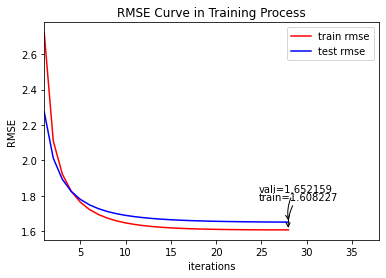

In [17]:
# Move test set to CUDA
if cuda:
    test_row = Variable(test_data[:, 0]).long().cuda()
    test_col = Variable(test_data[:, 1]).long().cuda()
else:
    test_row = Variable(test_data[:, 0]).long()
    test_col = Variable(test_data[:, 1]).long()

preds = model.predict(test_row, test_col)
 
# Get test rmse loss
if cuda:
    test_rmse = RMSE(preds.cpu().data.numpy(), test_data[:, 2].data.numpy())
else:
    test_rmse = RMSE(preds.data.numpy(), test_data[:, 2].data.numpy())
print('Test rmse: {:f}'.format(test_rmse))
 
# Create plots
plt.figure(1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color='r', label='train rmse')
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color='b', label='test rmse')
plt.legend()
plt.annotate(r'train=%f' % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.annotate(r'vali=%f' % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.title('RMSE Curve in Training Process')
plt.savefig('RMSE-Curve-PMF-yelp.png')
plt.show()
 

In [39]:
import pandas as pd

In [74]:
test_prediction_analysis = pd.DataFrame({'user':test_data[:, 0].numpy(), 'item': test_data[:, 1].numpy(),'predicted': preds.round().detach().long().numpy(), 'actual': test_data[:, 2].long().numpy()})

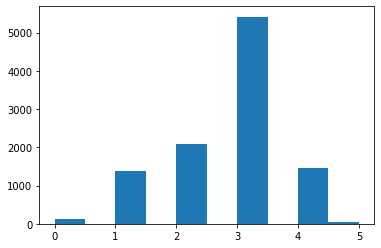

In [61]:
plt.hist(test_prediction_analysis['predicted'])
plt.show()

In [67]:
test_prediction_analysis.predicted.unique()

array([4, 3, 2, 0, 5, 1])

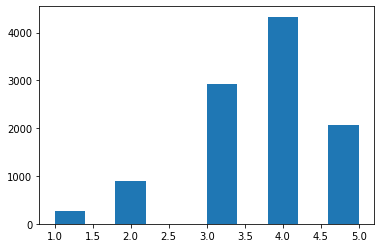

In [62]:
plt.hist(test_prediction_analysis['actual'])
plt.show()

In [68]:
test_prediction_analysis.actual.unique()

array([5, 2, 4, 3, 1])

In [79]:
model.predict(torch.tensor(520), torch.tensor(37984))

tensor(0.4011, grad_fn=<AddBackward0>)

In [71]:
for i in range(NUM_ITEMS):
    p = model.predict(torch.tensor(123), torch.tensor(i)).round().item()
    if p > 5:
        print(i, p)

In [75]:
test_prediction_analysis[test_prediction_analysis.predicted==0]

,user,item,predicted,actual
10,520,37984,0,3
66,543,36116,0,3
69,1022,16866,0,5
142,170,20972,0,2
145,97,3266,0,4
...,...,...,...,...
10099,955,30949,0,5
10407,1052,27354,0,5
10438,63,29802,0,5
10465,614,25443,0,2


In [80]:
test_prediction_analysis.to_csv('test_prediction_analysis-yelp.csv', index=None)